In [1]:
!pip install -q -U "tensorflow-text==2.8.*"

In [2]:
!pip install -q tf-models-official==2.7.0

In [3]:
!pip install -q pydot

In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
train_df = pd.read_csv('../data/processed/train_data_processed.csv', index_col='id')
train_df = train_df[train_df['language'] == 'English'].reset_index(drop=True)
train_df.head()

,title,genre,description,year,processed_description,processed_description_string,language
0,Oscar et la dame rose,drama,Listening in to a conversation between his do...,2009,"['listen', 'convers', 'doctor', 'parent', '10-...",listen convers doctor parent 10-year-old oscar...,English
1,Cupid,thriller,A brother and sister with a past incestuous r...,1997,"['brother', 'sister', 'past', 'incestu', 'rela...",brother sister past incestu relationship curre...,English
2,"Young, Wild and Wonderful",adult,As the bus empties the students for their fie...,1980,"['bu', 'empti', 'student', 'field', 'trip', 'm...",bu empti student field trip museum natur histo...,English
3,The Secret Sin,drama,To help their unemployed father make ends mee...,1915,"['help', 'unemploy', 'father', 'make', 'end', ...",help unemploy father make end meet edith twin ...,English
4,The Unrecovered,drama,The film's title refers not only to the un-re...,2007,"['film', 'titl', 'refer', 'un-recov', 'bodi', ...",film titl refer un-recov bodi ground zero also...,English


In [7]:
unique_genres = train_df['genre'].unique()
genre_encoding = dict([(unique_genres[i], i) for i in range(unique_genres.shape[0])])
train_df['genre'] = train_df['genre'].map(genre_encoding)
train_df = train_df.sample(frac=1)
train_df

,title,genre,description,year,processed_description,processed_description_string,language
17543,"""Klassi Ghalina""",4,When you taught that school has an age limit ...,2011,"['taught', 'school', 'age', 'limit', 'wrong', ...",taught school age limit wrong basic premis mal...,English
16938,Chosen by God: The Great Black Pharaohs of th...,3,CHOSEN BY GOD documents & details the work of...,2011,"['chosen', 'god', 'document', 'detail', 'work'...",chosen god document detail work world earliest...,English
34243,An Island's Legacy: Preparing for TT,3,Flexstone Pictures film 'things to do' while ...,2007,"['flexston', 'pictur', 'film', 'thing', 'visit...",flexston pictur film thing visit isl man isl m...,English
41142,The Hard Life,4,Centers on parents Bobby and Gina. Bobby is c...,2010,"['center', 'parent', 'bobbi', 'gina', 'bobbi',...",center parent bobbi gina bobbi charm witti tri...,English
41446,Panelstory aneb Jak se rodí sídliste,4,An old man is wandering round a badly signpos...,1980,"['old', 'man', 'wander', 'round', 'badli', 'si...",old man wander round badli signpost yet mostli...,English
...,...,...,...,...,...,...,...
23192,Road to El Paso,0,"Rancher Martin Auden's wife leaves him, his t...",2007,"['rancher', 'martin', 'auden', 'wife', 'leav',...",rancher martin auden wife leav tractor break h...,English
10591,Tattoo Two,4,Two best buddy entrepreneurs crash a high-pro...,2018,"['two', 'best', 'buddi', 'entrepreneur', 'cras...",two best buddi entrepreneur crash high-profil ...,English
24775,All the Presidents Elephants,3,What makes a jet setting 'power-blonde' busin...,2011,"['make', 'jet', 'set', 'power-blond', 'busi', ...",make jet set power-blond busi execut queenslan...,English
31214,Steven Spielberg's Director's Chair,18,Steven Spielberg's Director's Chair is a movi...,1996,"['steven', 'spielberg', 'director', 'chair', '...",steven spielberg director chair moviemak simul...,English


In [8]:
num_labels = train_df['genre'].nunique()
num_labels

27

In [9]:
x = train_df['processed_description_string'].values
# x = train_df['description'].values
y = pd.get_dummies(train_df['genre']).values

In [10]:
train_set_size = 45000
val_set_size = 4000
test_set_size = 4000

x_train = x[:train_set_size]
x_val = x[train_set_size:train_set_size+val_set_size]
x_test = x[train_set_size+val_set_size:train_set_size+val_set_size+test_set_size]

y_train = y[:train_set_size]
y_val = y[train_set_size:train_set_size+val_set_size]
y_test = y[train_set_size+val_set_size:train_set_size+val_set_size+test_set_size]

In [11]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [12]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

2022-11-19 14:46:04.459357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [13]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [14]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(128)(net)
    net = tf.keras.layers.Dropout(0.05)(net)
    net = tf.keras.layers.Dense(256)(net)
    net = tf.keras.layers.Dense(num_labels, activation='softmax')(net)
    return tf.keras.Model(text_input, net)

In [15]:
classifier_model = build_classifier_model()

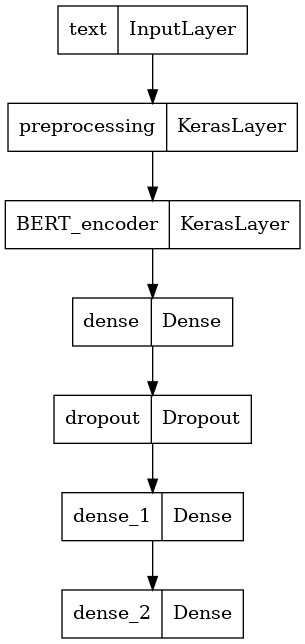

In [16]:
tf.keras.utils.plot_model(classifier_model, to_file='../models/{}.png'.format(bert_model_name))

In [17]:
epochs = 10

In [18]:
classifier_model.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [19]:
print(f'Training model with {tfhub_handle_encoder}')

my_callbacks  = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              mode='auto')]
history = classifier_model.fit(x_train, y_train,
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    callbacks=my_callbacks,
                    verbose=1
                   )

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/10
1407/1407 [==============================] - 49s 34ms/step - loss: 1.7724 - accuracy: 0.4797 - val_loss: 1.6002 - val_accuracy: 0.5250
Epoch 2/10
1407/1407 [==============================] - 48s 34ms/step - loss: 1.3734 - accuracy: 0.5970 - val_loss: 1.5542 - val_accuracy: 0.5497
Epoch 3/10
1407/1407 [==============================] - 48s 34ms/step - loss: 1.1316 - accuracy: 0.6655 - val_loss: 1.6388 - val_accuracy: 0.5420


In [20]:
loss, accuracy = classifier_model.evaluate(x_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

125/125 [==============================] - 3s 24ms/step - loss: 1.5845 - accuracy: 0.5535
Loss: 1.584531307220459
Accuracy: 0.5534999966621399


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


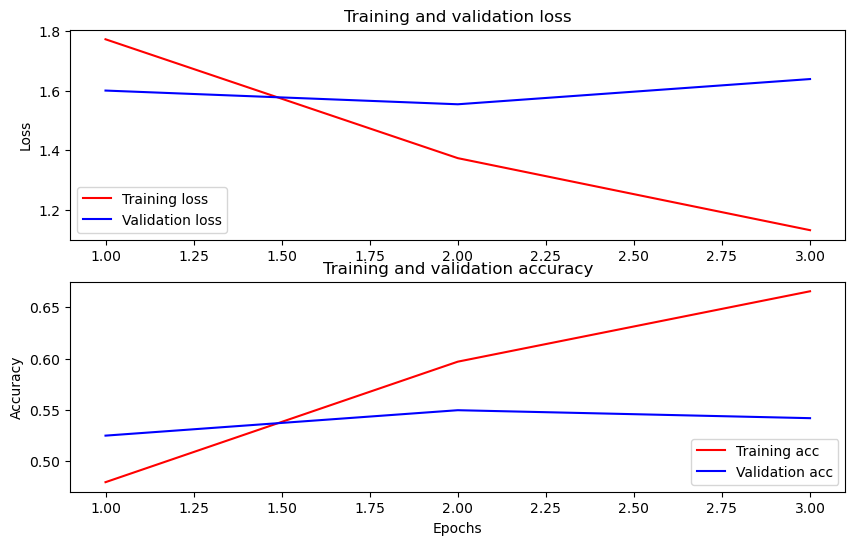

In [21]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [22]:
saved_model_path = '../models/{}'.format(bert_model_name)

classifier_model.save(saved_model_path, include_optimizer=False)

In [23]:
x_custom = np.array(['a hilarious tale'.lower()])

In [24]:
classifier_model.predict(x_custom)[0].argmax()

12

In [25]:
genre_encoding

{'drama': 0,
 'thriller': 1,
 'adult': 2,
 'documentary': 3,
 'comedy': 4,
 'crime': 5,
 'reality-tv': 6,
 'horror': 7,
 'sport': 8,
 'animation': 9,
 'action': 10,
 'fantasy': 11,
 'short': 12,
 'sci-fi': 13,
 'music': 14,
 'adventure': 15,
 'talk-show': 16,
 'western': 17,
 'family': 18,
 'mystery': 19,
 'history': 20,
 'news': 21,
 'biography': 22,
 'romance': 23,
 'game-show': 24,
 'musical': 25,
 'war': 26}